In [3]:
import numpy as np
import shapely
from shapely.geometry import Polygon
from shapely.plotting import plot_polygon, plot_points
import matplotlib.pyplot as plt

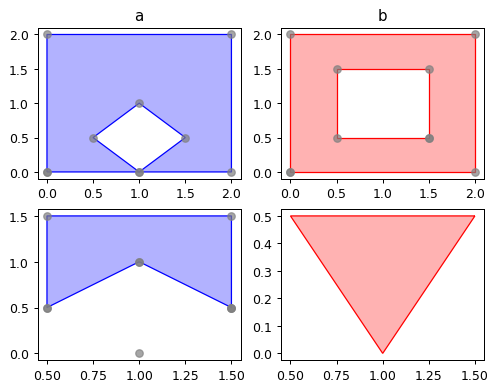

In [2]:
fig = plt.figure(1, dpi=90)

# 1: valid polygon
ax1 = fig.add_subplot(221)

ext = [(0, 0), (0, 2), (2, 2), (2, 0), (0, 0)]
int = [(1, 0), (0.5, 0.5), (1, 1), (1.5, 0.5), (1, 0)][::-1]
polygon_a = Polygon(ext, [int])

#2: invalid self-touching ring
ax2 = fig.add_subplot(222)
ext = [(0, 0), (0, 2), (2, 2), (2, 0), (0, 0)]
int = [(1.5, 0.5), (0.5, 0.5), (0.5, 1.5), (1.5, 1.5), (1.5, 0.5)][::-1]
polygon_b = Polygon(ext, [int])

plot_polygon(polygon_a, ax=ax1, add_points=False, color="blue")
plot_points(polygon_a, ax=ax1, color="gray", alpha=0.7)

ax1.set_title('a')

plot_polygon(polygon_b, ax=ax2, add_points=False, color="red")
plot_points(polygon_b, ax=ax2, color="gray", alpha=0.7)

ax2.set_title('b')

ax3 = fig.add_subplot(223)
plot_polygon(polygon_a.difference(polygon_b), ax=ax3, add_points=False, color="blue")
plot_points(polygon_a.difference(polygon_b), ax=ax3, color="gray", alpha=0.7)
ax4 = fig.add_subplot(224)
plot_polygon(polygon_b.difference(polygon_a), ax=ax4, add_points=False, color="red")
plot_points(polygon_b.difference(polygon_a), ax=ax3, color="gray", alpha=0.7)

plt.show()

In [3]:
from run_util import load_ENV
from environment import Environment
from Turtlebot_Kinematics import rotate

In [4]:
ENV = load_ENV("simple", False)
ENV.set_robo_state(np.array([800, 200, 0.3]))

loading simple


In [5]:
def internal_scan_coords():
    scan_dists = ENV.get_distance_scans()
    x, y, rho = ENV.get_internal_state()
    internal_pos = np.array([x,y])
    directions = [
        rotate(np.array([1.0,0.0]), angle) 
        for angle in 
        np.linspace(rho, np.pi * 2 + rho, len(scan_dists))
    ]
    return [internal_pos + dist * dire for i, (dist, dire) in enumerate(zip(scan_dists, directions))]

def scan_polys():
    scan_dists = ENV.get_distance_scans()
    scan_cords = internal_scan_coords()
    return shapely.unary_union([shapely.Point(cord) for cord,dist in zip(scan_cords, scan_dists) if dist <= 499])

def retransform_sensor(poly):
    int_x, int_y, rho = ENV.internal_offset
    robo_x, robo_y = ENV.get_robo_pos()
    poly = shapely.affinity.rotate(poly, rho, origin=(robo_x + int_x, robo_y + int_y), use_radians=True)
    poly = shapely.affinity.translate(poly, xoff = -int_x, yoff = -int_y)
    return poly

AttributeError: 'GeometryCollection' object has no attribute 'exterior'

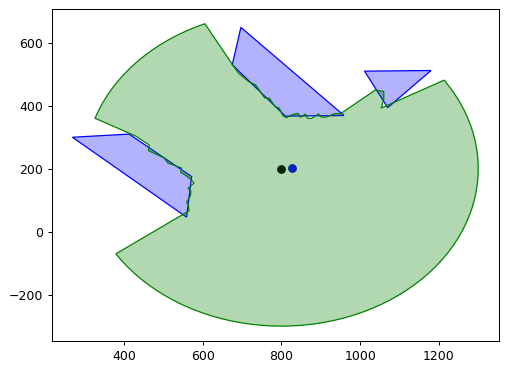

In [6]:
fig = plt.figure(1, dpi=90)

m_poly = shapely.unary_union([shapely.Polygon(obs.translate_corners()) for obs in ENV.map_obstacles + ENV.unknown_obstacles])
range_poly = shapely.Point(ENV.get_robo_pos()).buffer(500)
scan_coords = internal_scan_coords()
scan_x = [p[0] for p in scan_coords]
scan_y = [p[1] for p in scan_coords]
scan_poly = shapely.Polygon(scan_coords + [scan_coords[0]])
scan_poly = retransform_sensor(scan_poly)
fusion_poly = ENV.get_sensor_fusion()
fusion_poly = retransform_sensor(fusion_poly)


ax1 = fig.add_subplot(111)
ax1.scatter(ENV.get_robo_pos()[0], ENV.get_robo_pos()[1], color = "black")
ax1.scatter(ENV.get_internal_state()[0], ENV.get_internal_state()[1], color = "blue")
plot_polygon(m_poly, ax=ax1, add_points=False, color="blue")
plot_polygon(scan_poly, ax=ax1, add_points=False, color="green")
#plot_polygon(fusion_poly, ax=ax1, add_points=False, color="green")
plot_polygon(fusion_poly.simplify(5, preserve_topology = False), ax=ax1, add_points=False, color="red")
# ax1.plot(scan_x, scan_y, color="green")

plt.show()

In [6]:
for g in m_poly.geoms:
    print(list(g.exterior.coords))

NameError: name 'm_poly' is not defined

In [7]:
import timeit

ENV = load_ENV("simple", False)

def point_cloud_calc():
    fusion_poly = ENV.get_sensor_fusion(point_cloud=True)
    fusion_poly = retransform_sensor(fusion_poly)

def poly_calc():
    fusion_poly = ENV.get_sensor_fusion(point_cloud=False)
    fusion_poly = retransform_sensor(fusion_poly)


scan_dists = ENV.get_distance_scans
scan_cords = ENV.get_internal_scan_cords

dummy_dists = ENV.get_distance_scans()
dummy_coords = ENV.get_internal_scan_cords()
scan_point_cloud = lambda: shapely.unary_union([shapely.Point(cord) for cord,dist in zip(dummy_coords, dummy_dists) if dist <= ENV.max_scan_dist - 0.1])

map_poly = lambda: shapely.unary_union([shapely.Polygon(obs.translate_corners()) for obs in ENV.map_obstacles])

internal_coords = ENV.get_internal_scan_cords

dummy_point_cloud = scan_point_cloud()
dummy_poly = map_poly()
dummy_scan_coords = ENV.get_internal_scan_cords()
union = lambda: dummy_point_cloud.union(dummy_poly.difference(shapely.Polygon(dummy_scan_coords)))

"""
print("dists:", timeit.timeit(scan_dists, number=100))
print("coords:", timeit.timeit(scan_cords, number=100))
print("cloud:", timeit.timeit(scan_point_cloud, number=100))
print("map_poly:", timeit.timeit(map_poly, number=100))
print("intenal_coords:", timeit.timeit(internal_coords, number=100))
print("union:", timeit.timeit(union, number=100))
"""
print("Point_cloud:", timeit.timeit(point_cloud_calc, number=1000))
print("Polygon:", timeit.timeit(poly_calc, number=1000))


loading simple
Point_cloud: 13.618977400008589
Polygon: 15.533512499998324


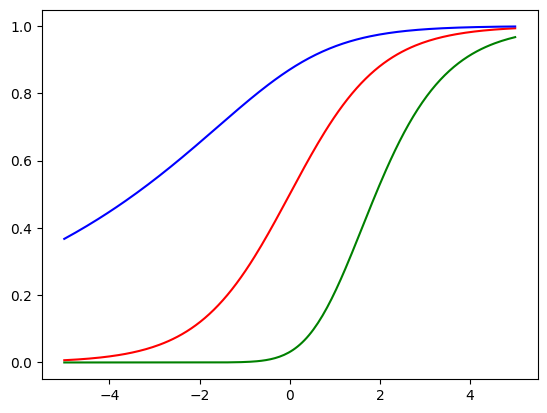

In [10]:
def sig(x):
    return np.e**x / (1 + np.e**x)

x = np.linspace(-5, 5, 200)
plt.plot(x, sig(x), color="red")
plt.plot(x, sig(x)**0.2, color="blue")
plt.plot(x, sig(x)**5, color="green")